# ECB Data Import

We want to import data directly from the [ECB data warehouse][warehouse], so for example rather than going to the [series] we want to download the [csv data][dl_csv]. In fact, the ECB provides three different download format (two csv's, one [generic][dl_csv] and [one for Excel][dl_xl]) and one [XML download][dl_xml].

There is is also an [sdmx query facility][dl_sdmx] that allows more granula control over what data will be downloaded.

[warehouse]:http://sdw.ecb.europa.eu/home.do
[series]:http://sdw.ecb.europa.eu/quickview.do?SERIES_KEY=123.ILM.W.U2.C.L022.U2.EUR
[dl_csv]:http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=123.ILM.W.U2.C.L022.U2.EUR&type=csv
[dl_xl]:http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=123.ILM.W.U2.C.L022.U2.EUR&type=xls
[dl_xml]:http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=123.ILM.W.U2.C.L022.U2.EUR&type=sdmx
[dl_sdmx]:http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=123.ILM.W.U2.C.L022.U2.EUR&type=sdmxQuery

The URI's are as follows (most also allow https):

- human readable series
~~~
http://sdw.ecb.europa.eu/quickview.do?SERIES_KEY=-key-
~~~
- csv file (generic and Excel format)
~~~
http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=-key-&type=csv
http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=-key-&type=xls
~~~
- sdmx file
~~~
http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=-key-&type=sdmx
~~~
- sdmx query and endpoint
~~~
http://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=-key-&type=sdmxQuery
http://sdw-ws.ecb.europa.eu/
~~~


## Class definitions
>note: all those class definitions have now been moved into module (`DataImport` and `PDataFrame` respectively). They will not longer be updated here.

### class `DataImport`

In [1]:
import urllib.request as req

class DataImport:
    """ web data import base class
    
    delimiter_row - if files are parsed, what delimits rows (default "\n")
    delimiter_col - if files are parsed, what delimits cols (default ",")
    
    
    DEPENDENCIES
    
    urllib.request
    """
    
    __version__ = "0.1a"
    
    def __init__(self, delimiter_row=None, delimiter_col=None):
        
        self.delimiter_row = delimiter_row or "\n"
        self.delimiter_col = delimiter_col or ","
        
    def fetch_raw(self, url):
        """ make a get request to a URL and return the contents
        
        url - the full url
        """
        result = req.urlopen(url)
        return result.readall()
    
    def parse_xsv(self, data, delimiter_row=None, delimiter_col=None):
        """ parses a data file that has already been downloaded into a list
        
        the format of the data file will by default csv, but any other format will do
        (depending on the paramters delimiter_row, delimiter_col which by default take
        the values set in the object which in turn default to "\n" and ",")
        
        data - the raw data
        delimiter_row - how rows are delimited
        delimiter_col - how cols are delimited
        
        """
        dlr = delimiter_row or self.delimiter_row
        dlc = delimiter_col or self.delimiter_col
        if type(data) != str: 
            data = data.decode("utf-8")
        result = data.split(dlr)
        result = list( row.split(dlc) for row in result)
        result = list( list( (item.strip()) for item in row) for row in result)
        #result = (  (  ( item.strip() for item in row.split(dlc))  ) for row in result)
        return list(result)
    
    def fetch_xsv(self, url, delimiter_row=None, delimiter_col=None):
        """ convenience function: fetch and parse as xsv
        """
        data = self.fetch_raw(url)
        return self.parse_xsv(data, delimiter_row, delimiter_col)
    

### class `ECBImport`

In [2]:
import re
from scipy.interpolate import interp1d

class ECBImport(DataImport):
    """ import data from the ECB statistics warehouse
    
    DEPENDENCIES
    
    re
    scipy.interpolate
    """
    
    __version__ = "0.1a"
    
    _urls = ("//sdw.ecb.europa.eu", "//sdw-ws.ecb.europa.eu/")
    
    def __init__(self, key=None, delimiter_row=None, delimiter_col=None):
        self.key = key
        super().__init__(delimiter_row, delimiter_col)
        return
    
    def url(self, which, key=None, https=False):
        """ defines the important endpoints
        
        which - which URL to return (see below)
        key - the series key (eg `123.ILM.W.U2.C.L022.U2.EUR` )
        https - whether to provide a https URL
        
        URL types in `which` are
        
        hr - humand readable
        csv, xls - csv formats
        sdmx - an xml format
        sdmx_q - a query string, to be used at the `sdmx_ep` endpoint
        sdmx_ep - then endpoint for sdmx queries
        """
        
        if key == None: key = self.key
        protocol = "https:" if https else "http:"
        
        if which == "sdmx_ep": return protocol + self._urls[1]

        url0 = protocol + self._urls[0] + "/quickview.do?SERIES_KEY=" + key
        url1 = protocol + self._urls[0] + "/quickviewexport.do?SERIES_KEY=" + key

        if which == "hr": return url0
        if which == "csv": return url1 + "&type=csv"
        if which == "xls": return url1 + "&type=xls"
        if which == "sdmx": return url1 + "&type=sdmx"
        if which == "sdmx_q": return url1 + "&type=sdmxquery"
           
        return None
    
    def fetch(self, key=None, skip_beg=0, skip_end=0):
        """ fetch an ECB data series
        
        key - the data series key
        skip_beg, skip_end - how many value to skip at the beginning and end of series; this
            is useful if two series with different time values are to be compared because
            the non-interpolated series must be restricted to an area within the interpolated
            one, otherwise the operation will fail
        """
        
        if key==None: key = self.key
        result = {'key': key}
        url = self.url("csv", key)
        data = self.fetch_xsv(url)
        result['descr_raw'] = data[0][0]
        result['descr'] = self.parse_xsv(result['descr_raw'], ";", ":")
        result['head'] = data[4]
        result['data'] = tuple(row for row in data[-1-skip_beg:5+skip_end:-1])
        return result
    
    @staticmethod
    def data_table(result, time_reformat_fn, unit=None, get_func=False):
        """ convert the data table into a proper numeric format
        
        result - the result, as return by fetch
        time_reformat_fn - the time reformatting function f(time_str) = time_float
            eg self.time_reformat1() for "2004w20"
            eg self.time_reformat2() for "2004feb"
        unit - optional unit in which val's are expressed (eg: 1000)
        get_func - if true, also return an interpolation function
        
        returns (time, val)
            time - tuple of floats for the time  (2000.0, ...)
            val - tuple of floats for the value
        """
        if unit == None: unit = 1.0
        data = result['data']
        time = tuple(time_reformat_fn(row[0])[0] for row in data)
        val = tuple(float(row[1]) / unit for row in data)
        if get_func == False: return (time, val)
        f = interp1d(time, val)
        return (time, val, f)
                
    @staticmethod
    def time_reformat1(time_str):
        """ reformat time of type 2004M12
        
        time_str - time [yyyyTii]
        
        T can be d/m/y
        returns (yyyy, T, ii, float_time) 
        
        test eg on ILM.W.U2.C.L022.U2.EUR
        """

        m = re.match("([0-9]+)([a-zA-Z]+)([0-9]+)", time_str);
        if m == None: return None
        g = m.groups()
        mult = {'d':365, 'w':52, 'm':12}[g[1].lower()];
        time =  float(g[0]) + (float(g[2])-1) / mult
        return (time, (g[1], int(g[0]), int(g[2])))
    
    
    @staticmethod
    def time_reformat2(time_str):
        """ reformat time of type 2004Jan
        
        time_str - time [yyyymmm]
        
        returns (yyyy, mm, float_time) 
        
        test eg on ILM.M.U2.C.A05B.U2.EUR
        """

        m = re.match("([0-9]+)([a-zA-Z]+)", time_str);
        if m == None: return None
        g = m.groups()
        month = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}[g[1].lower()];
        time =  float(g[0]) + (month - 1) / 12
        return (time, ('m', int(g[0]), month))


### class `PDataFrame`

In [3]:
import pandas as pd

class PDataFrame ():
    """ persistant DataFrame
    
    creates a pandas.DataFrame object and links it to a location on the disk 
    from which it is initialised and where it is saved back
    
    PDataFrame(filename, df)
        filename - the filename where the object is stored (as csv)
        df - if not none must be a DataFrame that is used to initialise the file
                note that the file will be overwritten!
        
    DEPENDENCIES
    
    pandas
    """
    
    __version__ = "0.1a"
    
    def __init__(self, filename, df=None):
        
        self._filename = filename
        
        if type(df) == type(None):
            self._df = pd.read_csv(filename, index_col=0)    
        else:
            self.reset(df)
 
    @staticmethod
    def create(filename, columns):
        """ creates an empty frame based on the field names in columns and saves it
        
        note that the file is overwritten if it exists
        this is _not_ a factory method; if the frame is to be used it needs to be 
        created thereafter:
            PDataFrame.create("new.csv", ['col1', 'col2'])
            pdf = PDataFrame("new.csv")
        """
        df = pd.DataFrame(columns=columns)
        df.to_csv(filename, index=True)
        
        
    def save(self):
        """ save the DataFrame to its location
        """
        self._df.to_csv(self._filename, index=True)
      
    def reset(self, df):
        """ reset the DataFrame to df and save it
        """
        self._df = df.copy()
        self.save()
        
    def set(self, key, values):
        """ sets a row in the dataframe (creating it if it does not exist) and saves it
        
        key - the key identifying the row; if this key exists the row in question
                will be overwritten, otherwise it appends a new one
        values - a tuple of values (must coincide with the number of fields)
        
        """
        self._df.loc[key] = values
        self.save()
        
    def get(self, key, field=None, asDict=True):
        """ gets a row in the dataframe
        
        field - if not None, only return the value of this particular field
        asDict - if True, returns it as dict (otherwise a pandas series; ignored if field != None)
        """
        if not asDict: return self._df.loc[key]
        d = dict(self._df.loc[key])
        if field == None: return d
        return d[field]
        
   
    def delete(self, idx):
        """deletes one row from the dataframe, based on the index value
        
        idx - the row to be deleted
        """
        
        self._df.loc[idx] = np.nan
        self._df = self._df.dropna()
        self.save()
        
    def length(self):
        """ returns the length of the dataframe
        """
        return len(self._df.index)
    
    def df(self):
        """ accessor function for the DataFrame object
        """
        return self._df

## Testing

### Bookmarks

that's a little side project, which is to create a file containing *bookmarks* for interesting series in the ECB database; it uses the `PDataFrame` class defined above.

Note that the following lines can generally be commented out: the whole idea here is that the bookmarks are kept in persistant storage (here the file `ECB_DataSeries.csv`) so one only has to execute `bm.set()` once to add a new bookmark (provided the csv file is being moved around with this note book)

In [6]:
PDataFrame.create('ECB_DataSeries.csv', ('key', 'description'))
bm = PDataFrame('ECB_DataSeries.csv')
bm.set('deposit', ('ILM.W.U2.C.L022.U2.EUR', 'current usage of the deposit facility'))
bm.set('lending', ('ILM.M.U2.C.A05B.U2.EUR', 'current aggregate usage of major lending facilities'))
bm.set('lending_marg', ('ILM.W.U2.C.A055.U2.EUR', 'current usage of the marginal lending facility'))


just to check what bookmarks we have defined...

In [7]:
bm = PDataFrame('ECB_DataSeries.csv')
bm._df

,key,description
deposit,ILM.W.U2.C.L022.U2.EUR,current usage of the deposit facility
lending,ILM.M.U2.C.A05B.U2.EUR,current aggregate usage of major lending facil...
lending_marg,ILM.W.U2.C.A055.U2.EUR,current usage of the marginal lending facility


...and how to get the values back

In [8]:
bm.get('deposit', 'key')

'ILM.W.U2.C.L022.U2.EUR'

### Data

we fetch three data series, the ECB deposit facility, the ECB lending facility, and the ECB marginal lending facility using the `fetch` method that takes as parameter the series key (see below and explanation for the `skip_end` parameter)

In [9]:
ei = ECBImport()
deposit = ei.fetch(bm.get('deposit', 'key'), skip_end=10)
lending = ei.fetch(bm.get('lending', 'key'))
lending_marg = ei.fetch(bm.get('lending_marg', 'key'))

the dataset returned contains a number of additonal info items, for example a description

In [10]:
deposit.keys()

dict_keys(['key', 'head', 'descr', 'data', 'descr_raw'])

In [11]:
deposit['descr']

[['Dataset name', 'Internal Liquidity Management'],
 ['Frequency', 'Weekly'],
 ['Reference area', 'Euro area (changing composition)'],
 ['BS reference sector breakdown', 'Eurosystem'],
 ['Balance sheet item', 'Deposit facility'],
 ['Counterpart area', 'Euro area (changing composition)'],
 ['Currency of transaction', 'Euro']]

The time information is in a funny format eg (eg, "2008w21"). So we then reformat the datatables into something that can be plotted, ie a float. For this we have the static method `data_table` that takes the data and a reformatting function for the time. Normally it returns a 2-tuple, the first component being the time-tuple, the second component being the value-tuple

If desired, additionally an interpolation function can be return as the third component. This is necessary if we want to do operations on series that are not based on the same time values. We see this in the last line below: `le[2]` is the interpolation function for the lending, and it is applied to `dp[0]` which are the time values for the deposit function. Now the two series are on the same basis and can hence be substracted (note that in `fetch()` we needed the `skip_end` parameter, because the available deposit data series goes further than the available lending series, which makes the interpolation fail). 

In [12]:
unit = 1000000
dp = ei.data_table(deposit, ei.time_reformat1, unit)
le = ei.data_table(lending, ei.time_reformat2, unit, True)
lm = ei.data_table(lending_marg, ei.time_reformat1, unit)
diff = le[2](dp[0]) - dp[1]

The functions for converting time are implemented as static methods on the object. For the time being there are two of them

In [13]:
ei.time_reformat1("2010w2")

(2010.0192307692307, ('w', 2010, 2))

In [14]:
ei.time_reformat2("2010mar")

(2010.1666666666667, ('m', 2010, 3))

We now can plot the data series. Note that that would not have been that trivial to do in Excel because one of the data series is monthly, the other one is weekly

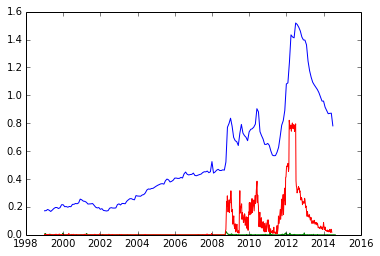

In [15]:
plot(le[0], le[1])
plot(lm[0], lm[1])
plot(dp[0], dp[1])

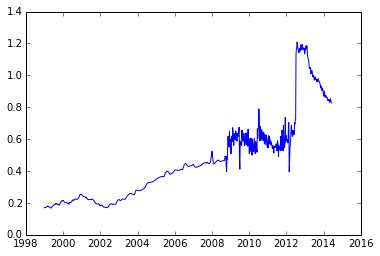

In [16]:
plot(dp[0], diff)